In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc
#from scipy.sparse import diags
#from numpy.linalg import solve

# Definition of constants and adimensional numbers

In [2]:
'''

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

------ Data definition and calculation of adimensional numbers and heat exchange coefficients -----

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

'''


'''
| Steel properties |
'''
Young_modulus = 177*10**9;
Poisson_coeff = 0.3;
Linear_expansion_coeff = 1.7*10**(-5);
k_vessel = 48.1;
mu_attenuation = 24;
sigma_yield = 181.5;
sigma_m = sigma_yield*2/3;
T_melt = 1450+273.15;

'''
| Primary fluid |
'''
p_design = 8.25*10**6;
T_1 = 214+273.15;
Cp_1 = 4534;
mu_1 = 1.259*10**-4;
k_1 = 0.658;
rho_1 = 852.5;
p_in = 8.25*10**6;
mass_flow_rate = 3227;

'''
| Containment water |
'''
beta = 5.57*10**(-4);
kinematic_viscosity = (4.06*10**(-4))/981.2;
rho_2 = 981.2;
mu_2 = 4.06*10**-4;
k_2 = 0.666;
p_2 = 7.5*10**6;
T_2 = 70+273.15;
Cp_2 = 4172.5;

'''
| Geometrical data |
'''
vessel_height = 7;
R_v_i = 1.5;
D_in = 3;

'''
| Gamma radiation |
'''
Gamma_flux = 1.5*10**(13)*10000;    # Photons/(m^2*s)
Gamma_energy = 6*1.6*10**(-13);     # Joules
Buildup = 1.4;

'''
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
'''

A_annulus = np.pi*((R_v_i)**2-(1.25)**2);
Inlet_speed = 3227/(852.5*A_annulus);


Reynolds = lambda rho, v, D, mu_viscosity : (rho*v*D)/mu_viscosity;
Dittus_boelter = lambda Re, Pr : 0.023*(Re**0.8)*(Pr**0.4);
Mc_Adams = lambda Gr, Pr: 0.13*((Gr*Pr)**(1/3));
Prandtl = lambda mu_viscosity, Cp, k: (mu_viscosity*Cp)/k;
Grashof = lambda beta, dT, L, nu : (9.81*beta*dT*(L**3))/(nu**2);   #dT = 30 kelvin
Max_thermal_stress = lambda sigma_T, alfa, E, q_V, k_vessel, nu, mu_attenuation: sigma_T*alfa*E*q_V/(k_vessel*(1-nu)*mu_attenuation**2);

h = lambda Nu, k_Water, diametre: Nu*k_Water/diametre;

thickness_min = (p_design)*(R_v_i)/((sigma_m*10**6)-(0.5*p_design));  #meters
thickness_real = thickness_min+thickness_min/10;
R_v_o = R_v_i + thickness_min;

# Adimensional numbers for case 1 - forced convection inside the vessel

Re_1 = Reynolds(rho_1, Inlet_speed, 0.5, mu_1);
Pr_1 = Prandtl(mu_1,Cp_1,k_1);
outer_D = 3 + thickness_real*2 + 0.05*2;
Nu_1 = Dittus_boelter(Re_1, Pr_1);
h1 = h(Nu_1, k_1, 0.5);


# Adimensional numbers for case 2 - natural convection outside the vessel

Gr_2 = Grashof(beta, 30, vessel_height, kinematic_viscosity);
Pr_2 = 4.06*10**-4*4172.5/0.666;
Nu_2 = Mc_Adams(Gr_2, Pr_2);
h2 = h(Nu_2, 0.666, vessel_height);

# Results

print("|-- RESULTS --|\n");
print(" Minimum thickness of the vessel (m): ", thickness_min);
print(" Real thickness of the vessel (m): ", thickness_real);
print(" Heat exchange coefficient inside the vessel (W/m^2K): ", h1);
print(" Heat exchange coefficient outside the vessel (W/m^2K): ", h2);

print("-------------------------------------------------------------------------");
print(" Adimensional numbers for case 1 - forced convection inside the vessel: ");
print("  Reynolds number: ", Re_1);
print("  Prandtl number: ", Pr_1);
print("  Nusselt number: ", Nu_1);
print("--------------------------------------------------------------------------");
print(" Adimensional numbers for case 2 - natural convection outside the vessel: ");

print("  Grashof number: ", Gr_2);
print("  Prandtl number: ", Pr_2);
print("  Nusselt number: ", Nu_2);
print("--------------------------------------------------------------------------");





|-- RESULTS --|

 Minimum thickness of the vessel (m):  0.10588235294117647
 Real thickness of the vessel (m):  0.11647058823529412
 Heat exchange coefficient inside the vessel (W/m^2K):  7498.127098751535
 Heat exchange coefficient outside the vessel (W/m^2K):  1164.8494200487205
-------------------------------------------------------------------------
 Adimensional numbers for case 1 - forced convection inside the vessel: 
  Reynolds number:  5933632.768951362
  Prandtl number:  0.8675237082066869
  Nusselt number:  5697.664968656181
--------------------------------------------------------------------------
 Adimensional numbers for case 2 - natural convection outside the vessel: 
  Grashof number:  328399577137755.1
  Prandtl number:  2.543596096096096
  Nusselt number:  12243.16207258415
--------------------------------------------------------------------------


## Thickness calculation using ASME criterion
We can compute the minimum thickness as:
\begin{equation}
t_{min} = \frac{p\cdot R_i}{\sigma_m-0.5p}
\end{equation}
Where $\sigma_m = 110\, \text{MPa}$, $p = 82.5\, \text{bar}$, $R_i = 1.5\, \text{m}$

In [3]:
thickness_min = (p_design)*(R_v_i)/((sigma_m*10**6)-(0.5*p_design));  #meters
thickness_real = thickness_min
thickness_buckling = thickness_real;
thickness_min, thickness_real, thickness_buckling

(0.10588235294117647, 0.10588235294117647, 0.10588235294117647)

# Buckling verification

## Buckling according to Corradi

In [4]:
q_E_fun = lambda Young_modulus, Poisson_coeff, external_D, thickness: 2*(Young_modulus/(1-Poisson_coeff**2))*1/((external_D/thickness)*(external_D/thickness -1)**2);
q_o_fun = lambda sigma_y, external_D, thickness: 2*sigma_y*thickness/external_D*(1+0.5*thickness/external_D);

'''
We evaluate the thickness by plugging the first guess (Mariotte) into the Corradi procedure,
then adjusting it retroactively in order to make the external pressure less then the allowable pressure

'''



'''Maximum ovality allowed (W) calculated as per ASME NB-4221.1'''

W = np.min([(2*R_v_i*1000+50)/(200)*(2*R_v_i*1000+1250)/200, 2*R_v_i*1000/100])/(2*R_v_i*1000);

'''Safety factor for Corradi chosen to be 2 since it is more conservative than 1.5'''

S_corr = 2;
q_c = p_2*S_corr;

'''The critical D/t ratio is the ratio at which the failure mechanism changes from plastic instability to elastic buckling'''

critical_D_over_t = np.sqrt(Young_modulus/(sigma_yield*10**6*(1-Poisson_coeff**2)));

k = 1/(1-Poisson_coeff**2)*Young_modulus/(sigma_yield*10**6);
while True:
    D_v_o = 2*(R_v_i+thickness_buckling);
    q_E = q_E_fun(Young_modulus, Poisson_coeff, D_v_o, thickness_buckling);
    q_o = q_o_fun(sigma_yield*10**6, D_v_o, thickness_buckling);
    z = np.sqrt(3)/4 * (2*D_v_o/thickness_buckling + 1) * W;
    q_L = 0.5*(q_o + q_E*(1+z)-np.sqrt((q_o + q_E*(1+z))**2 - 4*q_o*q_E));
    q_U = q_o/(np.sqrt(1+z**2));
    if (q_o/q_E)>0.7:
        mu_buckling = 0;
    else: 
        if (q_o/q_E)<=0.7 and (q_o/q_E)>=0.04:
            mu_buckling = 0.35*np.log(q_E/q_o)-0.125;
        else:
            mu_buckling = 1;
    
    q_Corradi = mu_buckling*q_U + (1-mu_buckling)*q_L;
    q_allowable_Corradi = q_Corradi/S_corr;
    
    if p_2<q_allowable_Corradi:
        break;
    else:
        thickness_buckling = thickness_buckling + 0.000001;


thickness_real = thickness_buckling*1.1;   #10% safety margin
R_v_o = R_v_i + thickness_real;

print("|-- RESULTS --|");

print("Minimum thickness (no buckling): {:.4f} m".format(thickness_min));
print("Real thickness (with buckling): {:.4f} m".format(thickness_real));
print("Allowable external pressure (Corradi): {:.2f} Pa".format(q_allowable_Corradi));
print("Critical D/t ratio: {:.2f}".format(critical_D_over_t));
print("Actual D/t ratio: {:.2f}".format(2*R_v_o/thickness_real));

    

|-- RESULTS --|
Minimum thickness (no buckling): 0.1059 m
Real thickness (with buckling): 0.1764 m
Allowable external pressure (Corradi): 7500060.41 Pa
Critical D/t ratio: 32.74
Actual D/t ratio: 19.01


# Overall heat transfer coefficient between the outer surface of the vessel and the CCP water

In [5]:
# overall heat exchange coefficient between the outer surface of the vessel and the containment water

R_ins_o = R_v_o + 0.05;

Thermal_resistence = R_v_o*np.log(R_ins_o/R_v_o)/(1.4) + R_v_o/(h2*R_ins_o);
U2 = 1/Thermal_resistence;

print("|-- HEAT EXCHANGE RESULTS --|");
print("Overall heat exchange coefficient U2: {:.2f} W/m^2K".format(U2));
print(f"Thermal resistence: {Thermal_resistence:.6f} m^2K/W");


|-- HEAT EXCHANGE RESULTS --|
Overall heat exchange coefficient U2: 27.76 W/m^2K
Thermal resistence: 0.036026 m^2K/W


# Volumetric heat generation in vessel with and without gamma heating

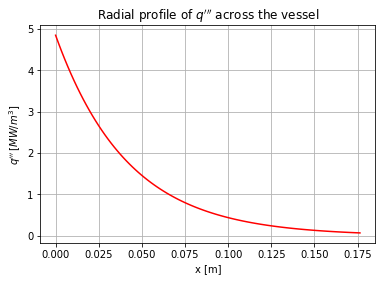

In [6]:
# volumetric heat generation in vessel due to gamma radiation

mu_attenuation = 24;  #1/meters
I0 = 1.4*6*1.602*10**(-13)*1.5*10**(13)*10000;
q0_V = I0*mu_attenuation;  #W/m3
x = np.linspace(0, thickness_real, 100);
q_V = I0*mu_attenuation*np.exp(-mu_attenuation*x);
plt.plot(x, q_V/1000000, color = "red");   # Q_V in MW/m3
plt.title("Radial profile of $q'''$ across the vessel");
plt.xlabel("x [m]");
plt.ylabel("$q''' \, [MW/m^3]$");
plt.grid();


In [7]:
# heat generation due to gamma in insulator

q0_V_insulator = q0_V*np.exp(-mu_attenuation*thickness_real);
print("|-- HEAT GENERATION RESULTS --|");
print("Volumetric heat generation at the inner surface of the vessel due to gamma radiation: {:.2f} W/m3".format(q0_V));
print("Volumetric heat generation at the inner surface of the insulator due to gamma radiation: {:.2f} W/m3".format(q0_V_insulator));

|-- HEAT GENERATION RESULTS --|
Volumetric heat generation at the inner surface of the vessel due to gamma radiation: 4844448.00 W/m3
Volumetric heat generation at the inner surface of the insulator due to gamma radiation: 70275.17 W/m3


## Temperature profile in the vessel with gamma heating

The temperature profile in the vessel is obtained by aproximating the Fourier equation for a cylinder as the equation for a slab, and considering a constant thermal conductivity for the steel:
\begin{equation}
\frac{\partial^2T}{\partial x^2} = -\frac{q_0'''}{k}e^{-\mu x}
\end{equation}

which, when integrated gives an analytical profile for the temperature in the vessel:

\begin{equation}
T(x) = -\frac{q_0'''}{k\mu^2}e^{-\mu x} + C_1 \,x + C_2
\end{equation}

and the constants are obtained by imposing boundary conditions on the thermal flux at the inner and outer surface:
\begin{equation}
h_1(T_1 - T(0)) = -k \left[\frac{dT}{dx}\right]_0
\end{equation}

\begin{equation}
U_2(T(L_v)-T_2) = -k\left[\frac{dT}{dx}\right]_{L_v}
\end{equation}

Where $L_v$ is the thickness of the vessel

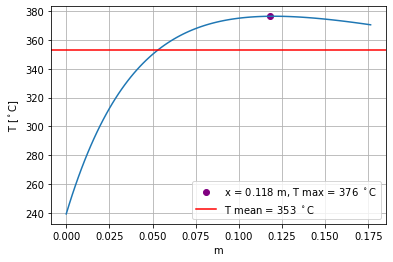

In [8]:
# analytical solution for Fourier equation in vessel witout thermal shield
def C1(T1, T2, q0_V, k_vessel, mu_attenuation, Lv, h1, u2):
    return ((q0_V/(k_vessel*mu_attenuation**2))*(np.exp(-mu_attenuation*Lv)-1)-(q0_V/mu_attenuation)*(1/h1 + np.exp(-mu_attenuation*Lv)/u2)-(T1-T2))/(Lv + k_vessel/h1 + k_vessel/u2)

def C2(T1, q0_V, h1, mu_attenuation, C1, k_vessel):
    return  T1 + q0_V/(h1*mu_attenuation) + C1*k_vessel/h1 + q0_V/(k_vessel*mu_attenuation**2);

def T(T1, T2, Lv, h1, u2, x, q_V, mu_attenuation, k_vessel):
    return -q_V/(k_vessel*mu_attenuation**2)*np.exp(-mu_attenuation*x) + C1(T1, T2, q_V, k_vessel, mu_attenuation, Lv, h1, u2)*x + C2(T1, q_V, h1, mu_attenuation, C1(T1, T2, q_V, k_vessel, mu_attenuation, Lv, h1, u2), k_vessel);

def T_mean_fun(q0_V, k_vessel, mu_attenuation, c1, c2, Lv):
    return q0_V/(k_vessel*mu_attenuation**2)*(np.exp(-mu_attenuation*Lv)-1)/(mu_attenuation*Lv) + (c1*Lv)/2 + c2;

Lv = thickness_real;
T1 = T_1;      # Supposing core inlet temperature does not vary in the downcomer and is not influenced by the heat generation in the core
T2 = T_2;
mu_attenuation = 24;
k_vessel = 48.1;
c1 = C1(T1, T2, q0_V, k_vessel, mu_attenuation, Lv, h1, U2);
c2 = C2(T1, q0_V, h1, mu_attenuation, c1, k_vessel);

T_mean = T_mean_fun(q0_V, k_vessel, mu_attenuation, c1, c2, Lv);

x = np.linspace(0, Lv, 100);
T_actual = np.zeros(100);

for i in range (100):
    T_actual[i] = T(T1, T2, Lv, h1, U2, x[i], q0_V, mu_attenuation, k_vessel);   # in Kelvin
    T_actual[i] = T_actual[i]-273.15;   # in Celsius

plt.plot(x, T_actual);
plt.grid();
#plt.title("Temperature profile across the vessel thickness");
plt.xlabel("m");
plt.scatter(np.argmax(T_actual)*Lv/100, np.max(T_actual), color = "purple", label = f"x = {np.argmax(T_actual)*Lv/100:.3g} m, T max = {np.max(T_actual):.3g} $^\circ$C");
plt.ylabel("T [$^\circ$C]");
plt.axhline(T_mean-273.15, color = "red", label = "T mean = {:.3g} $^\circ$C".format(T_mean-273.15));
plt.legend();



In [9]:
T_design = T_mean + 20;
T_mean-273.15, T_design-273.15   # T in celsius
x_max = np.argmax(T_actual)*Lv/100;

print("|-- TEMPERATURES --|");
print("Maximum temperature in the vessel wall: {:.2f} °C".format(np.max(T_actual)));
print("Mean temperature in the vessel wall: {:.2f} °C".format(T_mean-273.15));
print("Design temperature in the vessel wall: {:.2f} °C".format(T_design-273.15));
print("Position of maximum temperature in the vessel wall: {:.4f} m".format(x_max));

|-- TEMPERATURES --|
Maximum temperature in the vessel wall: 376.35 °C
Mean temperature in the vessel wall: 352.91 °C
Design temperature in the vessel wall: 372.91 °C
Position of maximum temperature in the vessel wall: 0.1182 m


The maximum temperature is above the limit for negligible creep according too ASME, which is already a sign that the thermal shield is needed

## Tmperature profile in vessel without gamma heating

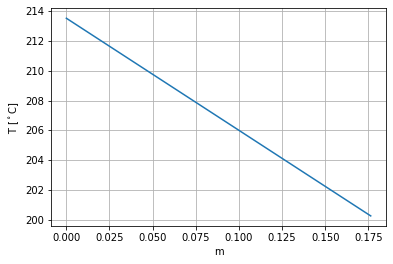

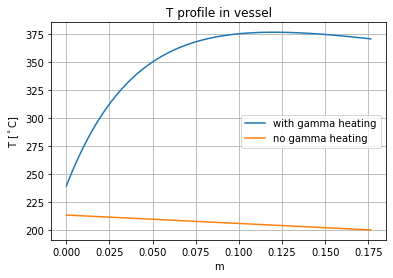

In [10]:
# temperature profile in vessel without gamma heat generation

T_no_gamma = np.zeros(100);
for i in range (100):
    T_no_gamma[i] = T(T1, T2, Lv, h1, U2, x[i], 0, mu_attenuation, k_vessel);   # in Kelvin
    T_no_gamma[i] = T_no_gamma[i]-273.15;   # in Celsius

plt.plot(x, T_no_gamma);
plt.grid();
#plt.title("Temperature profile inside the vessel (no gamma heating)")
plt.xlabel("m");
plt.ylabel("T [$^\circ$C]");
plt.show();
plt.plot(x, T_actual, label = "with gamma heating");
plt.plot(x, T_no_gamma, label = "no gamma heating");
plt.legend();
plt.grid();
plt.title("T profile in vessel");
plt.xlabel("m");
plt.ylabel("T [$^\circ$C]");
plt.show()

In [11]:
# thermal power flux with no gamma heating

q_no_gamma = -k_vessel*(T_no_gamma[99]-T_no_gamma[0])/thickness_real;
print("|-- HEAT FLUX RESULTS --|");
print("Thermal power flux through the vessel wall with no gamma heating: {:.2f} W/m2".format(q_no_gamma));

|-- HEAT FLUX RESULTS --|
Thermal power flux through the vessel wall with no gamma heating: 3615.73 W/m2


## Stress analysis in the vessel

We separate the thermal and mechanical problems since we are in the thermoelastic regime. The geometry of the problem is cylindrical, and we can assume axial symmetry and orthocylindricity. The cylinder can be approximated as thin since:

In [12]:
print(f"D/t ratio: {2*R_v_o/thickness_real}");

D/t ratio: 19.00852977767773


## Mechanical stresses according to Mariotte

We suppose a complete loss of continment water pressure. Thus, if we only have internal pressure, the stresses according to Mariotte are calculated as:
\begin{align*}
\sigma_{\theta} = p_{in}\frac{R_i}{t} \\
\sigma_r = -p_{in}/2 \\
\sigma_z = \sigma_{\theta}/2
\end{align*}

In [13]:
sigma_r_mariotte = -p_design/(2*10**6);
sigma_theta_mariotte = R_v_i*p_design/(10**6*thickness_real);
sigma_zeta_mariotte = sigma_theta_mariotte/2;
#sigma_zeta_mariotte = 0;
print("|-- STRESS RESULTS (MARIOTTE) --|");
print("Radial stress (Mariotte): {:.2f} MPa".format(sigma_r_mariotte));
print("Hoop stress (Mariotte): {:.2f} MPa".format(sigma_theta_mariotte));
print("Longitudinal stress (Mariotte): {:.2f} MPa".format(sigma_zeta_mariotte));

|-- STRESS RESULTS (MARIOTTE) --|
Radial stress (Mariotte): -4.12 MPa
Hoop stress (Mariotte): 70.16 MPa
Longitudinal stress (Mariotte): 35.08 MPa


We obtain the comparison stress according to Tresca and verify that it is less than $\sigma_m$

In [14]:
np.max([np.abs(sigma_r_mariotte-sigma_theta_mariotte), np.abs(sigma_theta_mariotte-sigma_zeta_mariotte), np.abs(sigma_zeta_mariotte-sigma_r_mariotte)]) < sigma_m

np.True_

However, since in normal operations we expect to have a different pressure on the outer and inner diameter we use Lamé theory for the mechanical stresses. We can assume plane strain solution since we want to avoid the vessel expanding along the z direction.

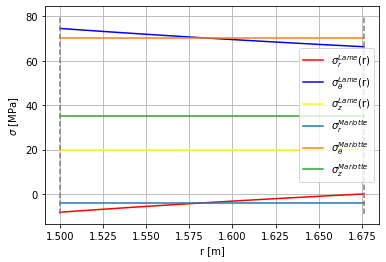

In [15]:
sigma_r_fun = lambda a, b, p_in, p_out, r: -(a*b)**2/(b**2-a**2)*(p_in-p_out)/r**2 + (a**2*p_in - b**2*p_out)/(b**2-a**2);
sigma_theta_fun = lambda a, b, p_in, p_out, r : (a**2*p_in-b**2*p_out)/(b**2-a**2) + (a*b)**2/(b**2-a**2)*(p_in-p_out)/r**2;

r =np.linspace(R_v_i, R_v_i+thickness_real, 100);
sigma_r = np.zeros(100);
sigma_theta = np.zeros(100);
for i in range (100):
    sigma_r[i] = sigma_r_fun(R_v_i, R_v_i+thickness_real, p_design/(10**6), 0, r[i]);
    sigma_theta[i] = sigma_theta_fun(R_v_i, R_v_i+thickness_real, p_design/(10**6), 0, r[i]);

#sigma_z_value = 2*Poisson_coeff*((R_v_i**2*p_design-R_v_o**2*p_2)/(R_v_o**2-R_v_i**2));
sigma_z = np.zeros(100);
for i in range(100):
    sigma_z[i] = Poisson_coeff*(sigma_r[i] + sigma_theta[i]);
    #sigma_z[i] = 0;

plt.plot(r, sigma_r, color = "red", label = "$\sigma_r^{Lame}$(r)");
plt.plot(r, sigma_theta, color = "blue", label = "$\sigma_{\\theta}^{Lame}$(r)");
plt.plot(r, sigma_z, color = "yellow", label = "$\sigma_z^{Lame}$(r)");
plt.plot(r, sigma_r_mariotte*np.ones(100),label = "$\sigma_r^{Mariotte}$");
plt.plot(r, sigma_theta_mariotte*np.ones(100), label = "$\sigma_{\\theta}^{Mariotte}$");
plt.plot(r, sigma_zeta_mariotte*np.ones(100), label = "$\sigma_z^{Mariotte}$");
plt.grid();
plt.legend();
#plt.title("Mechanical stresses across vessel thickness");
plt.xlabel("r [m]");
plt.ylabel("$\sigma$ [MPa]");
plt.vlines([R_v_i, R_v_i+thickness_real], -9, 80, linestyles="dashed", color = "grey");
plt.show()

In [16]:
sigma_theta_gradient = sigma_theta - sigma_theta_mariotte
sigma_r_gradient = sigma_r - sigma_r_mariotte
sigma_zeta_gradient = sigma_z - sigma_zeta_mariotte;
sigma_zeta_gradient_max = sigma_zeta_gradient[0];
sigma_r_gradient_max = sigma_r_gradient[0];
sigma_theta_gradient_max = sigma_theta_gradient[0];
sigma_theta_gradient_max, sigma_r_gradient_max, sigma_zeta_gradient_max


(np.float64(4.354058121397188),
 np.float64(-4.125000000000014),
 np.float64(-15.200819630164979))

In [17]:
# Stress tensor
sigma_mech_tensor = np.diag([sigma_r, sigma_theta, sigma_z]);

## Thermal stresses along the thickness of the vessel

The maximum hoop thermal stress is evaluated through the expression:
\begin{equation*}
\sigma_{\theta} = \sigma_T \frac{\alpha\, E \,q_0'''}{k \,(1-\nu)\,\mu^2}
\end{equation*}

This is a very conservative measure of the thermal hoop stress. The value of the axial stress is assumed to be equal to that of the hoop stress at the inner sirface of the vessel, since in that point the radial thermal stress is null seen as there are no constraints in that direction.

In [18]:
# Maximum hoop thermal stress along the vessel thickness

Radius_ratio = (R_v_i+thickness_real)/R_v_i;
design_parametre = mu_attenuation*R_v_i;
sigma_T = 0.68;

sigma_theta_thermal_max = Max_thermal_stress(sigma_T, Linear_expansion_coeff, Young_modulus, q0_V, k_vessel, Poisson_coeff, mu_attenuation);
sigma_theta_thermal_max=sigma_theta_thermal_max/10**6
sigma_z_thermal_max = sigma_theta_thermal_max;
print("|-- THERMAL STRESSES --|");
print("The maximum thermal stresses occur at the inner surface of the vessel wall.");
print("Maximum hoop thermal stress in the vessel wall: {:.2f} MPa".format(sigma_theta_thermal_max));
print("Maximum axial thermal stress in the vessel wall: {:.2f} MPa".format(sigma_z_thermal_max));


|-- THERMAL STRESSES --|
The maximum thermal stresses occur at the inner surface of the vessel wall.
Maximum hoop thermal stress in the vessel wall: 511.10 MPa
Maximum axial thermal stress in the vessel wall: 511.10 MPa


The actual distribution of the hoop thermal stress across the vessel depends on the difference between the local temperature and the average temperature in the vessel.

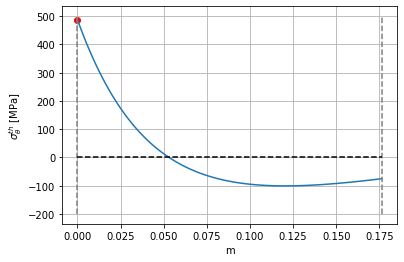

In [19]:
# actual thermal stress along the vessel

sigma_theta_thermal = np.zeros(100);
sigma_r_thermal = np.zeros(100);
for i in range(100):
    sigma_theta_thermal[i] = Linear_expansion_coeff*Young_modulus/(1-Poisson_coeff)*((T_mean-273.15)-T_actual[i]);
    sigma_theta_thermal[i] = sigma_theta_thermal[i]/10**6;

plt.plot(np.linspace(0, thickness_real, 100), sigma_theta_thermal);
plt.grid();
#plt.title("$\\sigma_{\\theta}^{th}$ profile across vessel thickness");
plt.xlabel("m");
plt.ylabel("$\\sigma_{\\theta}^{th}$ [MPa]");
plt.vlines([0, thickness_real], -200, 500, linestyles="dashed", color = "grey");
plt.hlines(0, 0, thickness_real, linestyles="dashed",color = "black");
plt.scatter(0, sigma_theta_thermal[0], color = "red");


In [20]:
# maximum hoop thermal stress calculated precisely
print("Maximum hoop thermal stress in the vessel wall (precise calculation): {:.2f} MPa".format(np.max(sigma_theta_thermal)));


Maximum hoop thermal stress in the vessel wall (precise calculation): 487.84 MPa


Thermal stresses are considered secondary since they are self-limiting. Thus, in order to verify wether the vessel is below yielding conditions, we must check that the secondary comparison stress according to Tresca is below $3\sigma_m$

In [21]:
# comparison stress according to tresca
sigma_total = [sigma_r_gradient_max + sigma_r_mariotte, sigma_theta_mariotte + sigma_theta_gradient_max + sigma_theta_thermal_max, sigma_zeta_mariotte + sigma_zeta_gradient_max+sigma_z_thermal_max];
sigma_c = np.max([abs(sigma_total[0]-sigma_total[1]), abs(sigma_total[1]-sigma_total[2]), abs(sigma_total[2]-sigma_total[0])]);

print("|-- TRESCA CRITERION --|");
print("Maximum stress difference according to Tresca criterion: {:.2f} MPa".format(sigma_c));
print("Is the vessel design safe according to Tresca criterion? ", sigma_c < 3*sigma_m);

|-- TRESCA CRITERION --|
Maximum stress difference according to Tresca criterion: 593.87 MPa
Is the vessel design safe according to Tresca criterion?  False


In [22]:
3*sigma_m

363.0

The thermal stress is too high and the shell will yield without a thermal shield

# Thermal shield

The presence of the thermal shield is needed in order to reduce the gamma flux that impinges on the vessel, thus reducing the heating and consequent thermal stresses. The requirements for the thermal shield material are that it should be able to effectively withstand neutron irradiation, and it should have a high $\mu \rho$ in order to effectively attenuate gamma radiation.

The material chosen for this reactor is the same as the vessel, since the steel has high attenuation coefficient. The choice of ferritic steel over austenitic steel is due to its lower heat conductivity, reducing thermal stresses across the thermal shield.

In [23]:
sigma_theta_thermal_max = 3*sigma_m+sigma_total[0]-sigma_theta_gradient_max-sigma_theta_mariotte

print("Required maximum hoop thermal stress to respect Tresca criterion: {:.2f} MPa".format(sigma_theta_thermal_max));


Required maximum hoop thermal stress to respect Tresca criterion: 280.24 MPa


In [24]:
q0_V_allowable = sigma_theta_thermal_max*10**6*k_vessel*(1-Poisson_coeff)*mu_attenuation**2/(sigma_T*Linear_expansion_coeff*Young_modulus);

print("Allowable volumetric heat generation to respect Tresca criterion: {:.2f} W/m3".format(q0_V_allowable));


Allowable volumetric heat generation to respect Tresca criterion: 2656183.33 W/m3


Since:
\begin{equation}
    q'''(x) = q_0'''e^{-\mu x}
\end{equation}
then the minimum thickness of the thermal shield is calculated as:
\begin{equation}
    s = -\frac{1}{\mu}\text{ln}\left(\frac{q_{allowable}'''}{q_0'''}\right)
\end{equation}

In [25]:
# minimum thickness calculation for the thermal shield
s_min = -1/mu_attenuation*np.log(q0_V_allowable/q0_V);
# s_min = s_min*3.7;
s_min = 1.1*s_min;

print("Minimum thickness of the thermal shield to respect Tresca criterion: {:.4f} m".format(s_min));

Minimum thickness of the thermal shield to respect Tresca criterion: 0.0275 m


In [26]:
offset = 0;
Shield_center = (R_v_i-1.25)/2 + 1.25 + offset;
R_s_i = Shield_center-s_min/2;
R_s_o = R_s_i+s_min;
A_annulus_inner = np.pi*((R_s_i)**2-(1.25)**2);
A_annulus_outer = np.pi*((R_v_i)**2-(R_s_o)**2);
A_annulus_tot = A_annulus_inner + A_annulus_outer;

avg_inlet_speed = mass_flow_rate/(rho_1*A_annulus_tot);
inlet_speed_outer = avg_inlet_speed;
inlet_speed_inner = avg_inlet_speed;

max_iterations = 1000;
iteration = 0;

while max_iterations>iteration:
    Re_inner = Reynolds(rho_1, inlet_speed_inner, 2*(R_s_i-1.25), mu_1);
    Re_outer = Reynolds(rho_1, inlet_speed_outer, 2*(R_v_i-R_s_o), mu_1);
    fanning_inner = 0.079*Re_inner**(-0.25);
    fanning_outer = 0.079*Re_outer**(-0.25);

    inlet_speed_outer = mass_flow_rate/(rho_1*(A_annulus_inner*np.sqrt((fanning_outer/fanning_inner)*(R_s_i-1.25)/(R_v_i-R_s_o))+A_annulus_outer));
    inlet_speed_inner = inlet_speed_outer*np.sqrt((fanning_outer/fanning_inner)*(R_s_i-1.25)/(R_v_i-R_s_o));
    iteration += 1;

print("|-- INLET VELOCITIES IN THE ANNULI --|");
print("Inlet speed in the inner annulus (between the shield and the barrel): {:.2f} m/s".format(inlet_speed_inner));
print("Inlet speed in the outer annulus (between the shield and the vessel): {:.2f} m/s".format(inlet_speed_outer));
print("Average inlet speed in the annuli: {:.2f} m/s".format(avg_inlet_speed));


|-- INLET VELOCITIES IN THE ANNULI --|
Inlet speed in the inner annulus (between the shield and the barrel): 1.97 m/s
Inlet speed in the outer annulus (between the shield and the vessel): 1.97 m/s
Average inlet speed in the annuli: 1.97 m/s


In [27]:

s_creep = s_min;
iter_num = 0;
while True:
    Shield_center_creep = (R_v_i-1.25)/2 + 1.25 + offset;
    R_s_i_creep = Shield_center_creep-s_creep/2;
    R_s_o_creep = R_s_i_creep+s_creep;
    A_annulus_inner_creep = np.pi*((R_s_i_creep)**2-(1.25)**2);
    A_annulus_outer_creep = np.pi*((R_v_i)**2-(R_s_o_creep)**2);
    A_annulus_tot_creep = A_annulus_inner_creep + A_annulus_outer_creep;

    avg_inlet_speed_creep = mass_flow_rate/(rho_1*A_annulus_tot_creep);
    inlet_speed_outer_creep = avg_inlet_speed_creep;
    inlet_speed_inner_creep = avg_inlet_speed_creep;

    max_iterations = 1000;
    iteration = 0;

    while max_iterations>iteration:
        Re_inner_creep = Reynolds(rho_1, inlet_speed_inner_creep, 2*(R_s_i_creep-1.25), mu_1);
        Re_outer_creep = Reynolds(rho_1, inlet_speed_outer_creep, 2*(R_v_i-R_s_o_creep), mu_1);
        fanning_inner_creep = 0.079*Re_inner_creep**(-0.25);
        fanning_outer_creep = 0.079*Re_outer_creep**(-0.25);

        inlet_speed_outer_creep = mass_flow_rate/(rho_1*(A_annulus_inner_creep*np.sqrt((fanning_outer_creep/fanning_inner_creep)*(R_s_i_creep-1.25)/(R_v_i-R_s_o_creep))+A_annulus_outer_creep));
        inlet_speed_inner_creep = inlet_speed_outer_creep*np.sqrt((fanning_outer_creep/fanning_inner_creep)*(R_s_i_creep-1.25)/(R_v_i-R_s_o_creep));
        iteration += 1;
    '''
    Re_1_shield = Reynolds(rho_1, inlet_speed_2, 2*R_s_i-2.5, mu_1);
    Pr_1_shield = Prandtl(mu_1, Cp_1, k_1);
    Nu_1_shield = Dittus_boelter(Re_1_shield, Pr_1_shield);
    h1_shield = h(Nu_1_shield, k_1, 2*R_s_i-2.5);

    Re_2_shield = Reynolds(rho_1, inlet_speed_2, 2*R_v_i-2*R_s_o, mu_1);
    Pr_2_shield = Prandtl(mu_1, Cp_1, k_1);
    Nu_2_shield = Dittus_boelter(Re_2_shield, Pr_2_shield);
    h2_shield = h(Nu_2_shield, k_1, 2*R_v_i-2*R_s_o)


    x_shield = np.linspace(0, s_creep, 100);
    T_shield = np.zeros(100);
    for i in range (100):
        T_shield[i] = T(T1, T1, s_creep, h1_shield, h2_shield, x_shield[i], q0_V_allowable, mu_attenuation, k_vessel)-273.15;

    T_mean_thermal_shield = T_mean_fun(q0_V_allowable, k_vessel, mu_attenuation, C1(T1, T1, q0_V_allowable, k_vessel, mu_attenuation, s_creep, h1_shield, h2_shield), C2(T1, q0_V_allowable, h1_shield, mu_attenuation, C1(T1, T1, q0_V_allowable, k_vessel, mu_attenuation, s_creep, h1_shield, h2_shield), k_vessel), s_creep);
    T_mean_thermal_shield = T_mean_thermal_shield-273.15;
    '''
    #A_annulus_2 = A_annulus - np.pi*((R_s_o)**2-(R_s_i)**2);
    #inlet_speed_2 = 3227/(852.5*A_annulus_2);

    Re_1_with_shield = Reynolds(rho_1, inlet_speed_outer_creep, 2*R_v_i-2*R_s_o_creep, mu_1);
    Pr_1_with_shield = Prandtl(mu_1, Cp_1, k_1);
    Nu_1_with_shield = Dittus_boelter(Re_1_with_shield, Pr_1_with_shield);
    h1_with_shield = h(Nu_1_with_shield, k_1, 2*R_v_i-2*R_s_o_creep);

    q0_V_with_shield = q0_V*np.exp(-mu_attenuation*s_creep);

    c1_with_shield = C1(T_1, T_2, q0_V_with_shield, k_vessel, mu_attenuation, thickness_real, h1_with_shield, U2);
    c2_with_shield = C2(T_1, q0_V_with_shield, h1_with_shield, mu_attenuation, c1_with_shield, k_vessel);

    T_with_shield = T(T_1, T_2, thickness_real, h1_with_shield, U2, np.linspace(0, thickness_real, 100), q0_V_with_shield, mu_attenuation, k_vessel);
    iter_num = iter_num+1;
    if np.max(T_with_shield)<0.29*T_melt or iter_num>1000:
        break;
    else:
        s_creep = s_creep + 0.0001;


'''
plt.plot(np.linspace(0, s_min, 100), T_shield);
plt.scatter(np.argmax(T_shield)*s_min/100, np.max(T_shield), color = "purple", label = f"x = {np.argmax(T_shield)*s_min/100:.3g}");
plt.hlines(T_mean_thermal_shield, 0, s_min, color = "red", label ="$T_{mean}$" );
plt.legend();
plt.grid();
plt.title("Temperature profile across the thermal shield thickness");
plt.xlabel("m");
plt.ylabel("T [$^\circ$C]");
plt.show();
'''
print("|-- RESULTS FOR THERMAL SHIELD FOR NO CREEP IN THE VESSEL --|");
print("minimum thickness of the thermal shield to keep max vessel temperature under 0.29 T_melt: {:.4f} m".format(s_creep));
print("maximum temperature in the vessel with the thermal shield: {:.2f} °C".format(np.max(T_with_shield)-273.15));
print("T/T_melt ratio with the thermal shield: {:.4f}".format(np.max(T_with_shield)/T_melt));
print("inlet speed in the outer annulus with the thermal shield: {:.2f} m/s".format(inlet_speed_outer_creep));
print("inlet speed in the inner annulus with the thermal shield: {:.2f} m/s".format(inlet_speed_inner_creep));


|-- RESULTS FOR THERMAL SHIELD FOR NO CREEP IN THE VESSEL --|
minimum thickness of the thermal shield to keep max vessel temperature under 0.29 T_melt: 0.0871 m
maximum temperature in the vessel with the thermal shield: 226.52 °C
T/T_melt ratio with the thermal shield: 0.2900
inlet speed in the outer annulus with the thermal shield: 2.69 m/s
inlet speed in the inner annulus with the thermal shield: 2.69 m/s


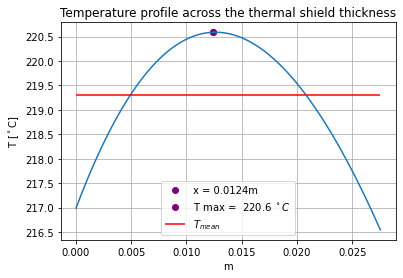

In [28]:
Re_1_shield = Reynolds(rho_1, inlet_speed_inner, 2*R_s_i-2.5, mu_1);
Pr_1_shield = Prandtl(mu_1, Cp_1, k_1);
Nu_1_shield = Dittus_boelter(Re_1_shield, Pr_1_shield);
h1_shield = h(Nu_1_shield, k_1, 2*R_s_i-2.5);

Re_2_shield = Reynolds(rho_1, inlet_speed_outer, 2*R_v_i-2*R_s_o, mu_1);
Pr_2_shield = Prandtl(mu_1, Cp_1, k_1);
Nu_2_shield = Dittus_boelter(Re_2_shield, Pr_2_shield);
h2_shield = h(Nu_2_shield, k_1, 2*R_v_i-2*R_s_o)


x_shield = np.linspace(0, s_min, 100);
T_shield = np.zeros(100);
for i in range (100):
    T_shield[i] = T(T1, T1, s_min, h1_shield, h2_shield, x_shield[i], q0_V_allowable, mu_attenuation, k_vessel)-273.15;

T_mean_thermal_shield = T_mean_fun(q0_V_allowable, k_vessel, mu_attenuation, C1(T1, T1, q0_V_allowable, k_vessel, mu_attenuation, s_min, h1_shield, h2_shield), C2(T1, q0_V_allowable, h1_shield, mu_attenuation, C1(T1, T1, q0_V_allowable, k_vessel, mu_attenuation, s_min, h1_shield, h2_shield), k_vessel), s_min);
T_mean_thermal_shield = T_mean_thermal_shield-273.15;

plt.plot(np.linspace(0, s_min, 100), T_shield);
plt.scatter(np.argmax(T_shield)*s_min/100, np.max(T_shield), color = "purple", label = f"x = {np.argmax(T_shield)*s_min/100:.3g}m");
plt.scatter(np.argmax(T_shield)*s_min/100, np.max(T_shield), color = "purple", label = f"T max =  {np.max(T_shield):.4g} $^\circ C$");
plt.hlines(T_mean_thermal_shield, 0, s_min, color = "red", label ="$T_{mean}$" );
plt.legend();
plt.grid();
plt.title("Temperature profile across the thermal shield thickness");
plt.xlabel("m");
plt.ylabel("T [$^\circ$C]");
plt.show();

## Stress evaluation in the thermal shield

Mechanical stresses in the thrmal shield are null since internal pressure is equal to external pressure and even in case of accident the pressure would be equal on both sides

In [29]:
T_mean_thermal_shield = T_mean_fun(q0_V_allowable, k_vessel, mu_attenuation, C1(T1, T1, q0_V_allowable, k_vessel, mu_attenuation, s_min, h1_shield, h2_shield), C2(T1, q0_V_allowable, h1_shield, mu_attenuation, C1(T1, T1, q0_V_allowable, k_vessel, mu_attenuation, s_min, h1_shield, h2_shield), k_vessel), s_min);
T_mean_thermal_shield = T_mean_thermal_shield-273.15;
print("|-- THERMAL SHIELD RESULTS --|");
print("Minimum thickness of the thermal shield to respect Tresca criterion: {:.4f} m".format(s_min));
print("Maximum temperature in the thermal shield: {:.2f} °C".format(T_max_shield));
print("Mean temperature in the thermal shield: {:.2f} °C".format(T_mean_thermal_shield));
print("Design temperature in the thermal shield: {:.2f} °C".format(T_mean_thermal_shield + 20));

|-- THERMAL SHIELD RESULTS --|
Minimum thickness of the thermal shield to respect Tresca criterion: 0.0275 m


NameError: name 'T_max_shield' is not defined

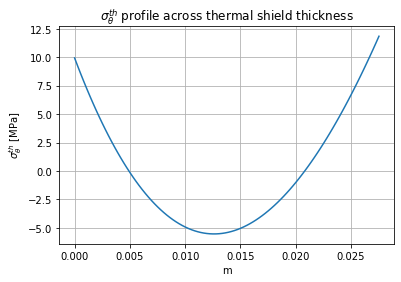

In [ ]:
sigma_theta_thermal_thermal_shield = np.zeros(100);
for i in range(100):
    sigma_theta_thermal_thermal_shield[i] = Linear_expansion_coeff*Young_modulus/(1-Poisson_coeff)*((T_mean_thermal_shield)-T_shield[i]);
    sigma_theta_thermal_thermal_shield[i] = sigma_theta_thermal_thermal_shield[i]/10**6;

plt.plot(x_shield, sigma_theta_thermal_thermal_shield);
plt.grid();
plt.title("$\\sigma_{\\theta}^{th}$ profile across thermal shield thickness");
plt.xlabel("m");
plt.ylabel("$\\sigma_{\\theta}^{th}$ [MPa]");

Since the thermal stress along r is null at the borders since there are no constraints and $\sigma_z = \sigma_{\theta} + \sigma_r$, we have that the maximum stress is found at the borders where it is equal to $\sigma_{\theta}$
In terms of mechanical stresses, we cannot use Mariotte since the inner and outer pressures are equal, so we use Lamé and add it to the thermal stresses

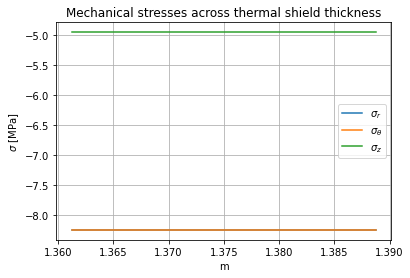

In [ ]:
sigma_r_lame_thermal_shield = sigma_r_fun(R_s_i, R_s_o, p_design, p_design, np.linspace(R_s_i, R_s_o, 100));
sigma_theta_lame_thermal_shield = sigma_theta_fun(R_s_i, R_s_o, p_design, p_design, np.linspace(R_s_i, R_s_o, 100));
sigma_zeta_lame_thermal_shield = np.zeros(100);

for i in range(100):
    sigma_r_lame_thermal_shield[i] = sigma_r_lame_thermal_shield[i]/10**6;
    sigma_theta_lame_thermal_shield[i] = sigma_theta_lame_thermal_shield[i]/10**6;
    sigma_zeta_lame_thermal_shield[i] = Poisson_coeff*(sigma_r_lame_thermal_shield[i] + sigma_theta_lame_thermal_shield[i]);

plt.plot(np.linspace(R_s_i, R_s_o, 100), sigma_r_lame_thermal_shield);
plt.plot(np.linspace(R_s_i, R_s_o, 100), sigma_theta_lame_thermal_shield);
plt.plot(np.linspace(R_s_i, R_s_o, 100), sigma_zeta_lame_thermal_shield);
plt.grid();
plt.title("Mechanical stresses across thermal shield thickness");
plt.xlabel("m");
plt.ylabel("$\sigma$ [MPa]");
plt.legend(["$\sigma_r$", "$\sigma_{\\theta}$", "$\sigma_z$"]);
plt.show()

In [ ]:
print("|-- LAME STRESSES IN THE THERMAL SHIELD --|");
print("Maximum axial stress in the thermal shield: {:.2f} Pa".format(np.max(sigma_zeta_lame_thermal_shield)));
print("Maximum hoop stress in the thermal shield: {:.2f} Pa".format(np.max(sigma_theta_lame_thermal_shield)));
print("Maximum radial stress in the thermal shield: {:.2f} Pa".format(np.max(sigma_r_lame_thermal_shield)));

|-- LAME STRESSES IN THE THERMAL SHIELD --|
Maximum axial stress in the thermal shield: -4.95 Pa
Maximum hoop stress in the thermal shield: -8.25 Pa
Maximum radial stress in the thermal shield: -8.25 Pa


In [ ]:
np.max(sigma_theta_thermal_thermal_shield)

np.float64(11.856725037470492)

In [ ]:
sigma_total_thermal_shield = [sigma_r_lame_thermal_shield[0], sigma_theta_lame_thermal_shield[0] + np.max(sigma_theta_thermal_thermal_shield), sigma_zeta_lame_thermal_shield[0]+np.max(sigma_theta_thermal_thermal_shield)];
sigma_c_thermal_shield = np.max([abs(sigma_total_thermal_shield[0]-sigma_total_thermal_shield[1]), abs(sigma_total_thermal_shield[1]-sigma_total_thermal_shield[2]), abs(sigma_total_thermal_shield[2]-sigma_total_thermal_shield[0])]);
print("|-- TRESCA CRITERION FOR THE THERMAL SHIELD --|");
print("Maximum stress difference according to Tresca criterion in the thermal shield: {:.2f} MPa".format(sigma_c_thermal_shield));
print("Is the thermal shield design safe according to Tresca criterion? ", sigma_c_thermal_shield < 3*sigma_m);


|-- TRESCA CRITERION FOR THE THERMAL SHIELD --|
Maximum stress difference according to Tresca criterion in the thermal shield: 15.16 MPa
Is the thermal shield design safe according to Tresca criterion?  True


The stress conditions are allowable, since primary stresses are absent and secondary stresses are well below $\sigma_m$

# Recalculation of heat exchange with the presence of thermal shield

Temperature profile in the vessel with the presence of the thermal shield

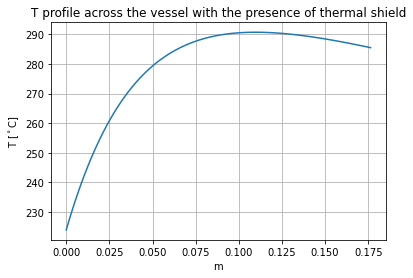

In [ ]:

A_annulus_2 = A_annulus - np.pi*((R_s_o)**2-(R_s_i)**2);
inlet_speed_2 = 3227/(852.5*A_annulus_2);

Re_1_with_shield = Reynolds(rho_1, inlet_speed_outer, 2*R_v_i-2*R_s_o, mu_1);
Pr_1_with_shield = Prandtl(mu_1, Cp_1, k_1);
Nu_1_with_shield = Dittus_boelter(Re_1_with_shield, Pr_1_with_shield);
h1_with_shield = h(Nu_1_with_shield, k_1, 2*R_v_i-2*R_s_o);

q0_V_with_shield = q0_V*np.exp(-mu_attenuation*s_min);

c1_with_shield = C1(T_1, T_2, q0_V_with_shield, k_vessel, mu_attenuation, thickness_real, h1_with_shield, U2);
c2_with_shield = C2(T_1, q0_V_with_shield, h1_with_shield, mu_attenuation, c1_with_shield, k_vessel);

T_with_shield = T(T_1, T_2, thickness_real, h1_with_shield, U2, np.linspace(0, thickness_real, 100), q0_V_with_shield, mu_attenuation, k_vessel)-273.15;
plt.plot(np.linspace(0, thickness_real, 100), T_with_shield);
plt.grid(); 
plt.title("T profile across the vessel with the presence of thermal shield");
plt.xlabel("m");
plt.ylabel("T [$^\circ $C]");


In [ ]:
T_max_with_shield = np.max(T_with_shield)+273.15
T_max_with_shield/(1450+273.15), T_max_with_shield-273.15, q0_V_with_shield

(np.float64(0.3272164857638274),
 np.float64(290.69308744393925),
 np.float64(2501263.365662665))

## Stress verification in the vessel with thermal shield

Actual thermal stress across the vessel

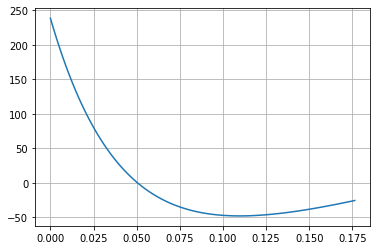

In [ ]:
T_mean_with_sh = T_mean_fun(q0_V_with_shield, k_vessel, mu_attenuation, c1_with_shield, c2_with_shield, thickness_real)-273.15;

sigma_theta_thermal_with_sh = Linear_expansion_coeff*Young_modulus/(1-Poisson_coeff)*(T_mean_with_sh-T_with_shield)/10**6;

plt.plot(np.linspace(0, thickness_real, 100), sigma_theta_thermal_with_sh);
plt.grid();

Max (conservative) hoop thermal stress across the vessel

In [ ]:
sigma_theta_thermal_max_with_sh = Max_thermal_stress(sigma_T, Linear_expansion_coeff, Young_modulus, q0_V_with_shield, k_vessel, Poisson_coeff, mu_attenuation)/10**6;
sigma_theta_thermal_max_with_sh

np.float64(263.8912090876776)

Stress verification on vessel with thermal shield

In [ ]:
sigma_total_with_shield = [sigma_r_gradient_max + sigma_r_mariotte, sigma_theta_mariotte + sigma_theta_gradient_max+sigma_theta_thermal_max_with_sh, sigma_zeta_mariotte +sigma_zeta_gradient_max + sigma_theta_thermal_max_with_sh];
sigma_c_with_shield = np.max([np.abs(sigma_total_with_shield[0]-sigma_total_with_shield[1]), np.abs(sigma_total_with_shield[0]-sigma_total_with_shield[2]), np.abs(sigma_total_with_shield[1]-sigma_total_with_shield[2])]);
sigma_c_with_shield, sigma_total_with_shield, sigma_c_with_shield <= 3*sigma_m, 3*sigma_m

(np.float64(346.6554525419955),
 [np.float64(-8.250000000000014),
  np.float64(338.4054525419955),
  np.float64(283.77048212397295)],
 np.True_,
 363.0)